In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error, make_scorer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import pickle
import hyperopt.pyll.stochastic
import time
from xgboost import XGBRegressor

/home/csc/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['loss'] = np.nan
joined = pd.concat([train, test])

In [7]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [8]:
for column in list(train.select_dtypes(include=['object']).columns):
    if train[column].nunique() != test[column].nunique():
        set_train = set(train[column].unique())
        set_test = set(test[column].unique())
        remove_train = set_train - set_test
        remove_test = set_test - set_train

        remove = (remove_train|remove_test)
        def filter_cat(x):
            if x in remove:
                return np.nan
            return x

        joined[column] = joined[column].apply(lambda x: np.nan if x in remove else x, 1)

    joined[column] = pd.factorize(joined[column].values, sort=True)[0]

train = joined[joined['loss'].notnull()]
test = joined[joined['loss'].isnull()]

shift = 200
y = np.log(train['loss'] + shift)
ids = test['id']
X = train.drop(['loss', 'id'], 1)
X_test = test.drop(['loss', 'id'], 1)
xgtrain = xgb.DMatrix(X, label=y)
xgtest = xgb.DMatrix(X_test)

In [ ]:
#1148.9639894 {'reg_alpha': 0.13614510960026047, 'colsample_bytree': 0.48613283826428166, 'scale_pos_weight': 1, 'learning_rate': 0.018415349849039475, 'nthread': 10, 'min_child_weight': 3, 'subsample': 0.8045758877474857, 'max_depth': 16, 'gamma': 3.738381824865164}
RANDOM_STATE = 0
'''params = {
    'min_child_weight': 1,
    'eta': 0.01,
    'colsample_bytree': 0.5,
    'max_depth': 12,
    'subsample': 0.8,
    'alpha': 1,
    'gamma': 1,
    'silent': 1,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'nthread':10
}'''
params={
    'seed': 0,
    'colsample_bytree': 0.4,
    'silent': 1,
    'subsample': 0.975,
    'learning_rate': 0.015,
    'gamma': 1.5,
    'lambda': 2,
    'alpha': 2,
    'max_depth': 25,
    'num_parallel_tree': 1,
    'min_child_weight': 50,
    'eval_metric': 'mae',
    'max_delta_step': 0,
}
xgtrain = xgb.DMatrix(X, label=y)
xgtest = xgb.DMatrix(X_test)
model = xgb.train(params, xgtrain, int(2012 / 0.9), feval=evalerro

In [27]:
prediction = np.exp(model.predict(xgtest)) - shift
submission = pd.DataFrame()
submission['loss'] = prediction
submission['id'] = ids
submission.to_csv('sub_v.csv', index=False)

In [45]:
#eta_list  = [0.1]*100 + [0.05]*200 + [0.02]*400
#model = xgb.train(params, xgtrain, 700, feval=evalerror)

In [9]:
xgb_params={
    'seed': 0,
    'colsample_bytree': 0.4,
    'silent': 1,
    'subsample': 0.975,
    'learning_rate': 0.015,
    'gamma': 1.5,
    'lambda': 2,
    'alpha': 2,
    'max_depth': 25,
    'num_parallel_tree': 1,
    'min_child_weight': 50,
    'eval_metric': 'mae',
    'max_delta_step': 0,
}
%%time
bst_cv1 = xgb.cv(xgb_params, xgtrain, num_boost_round=int(2012 / 0.9), nfold=3, seed=0, stratified=False,
                    feval=evalerror, maximize=False, early_stopping_rounds=None)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

In [25]:
np.min(bst_cv1.iloc[:]['test-mae-mean'])

1132.4604492000001

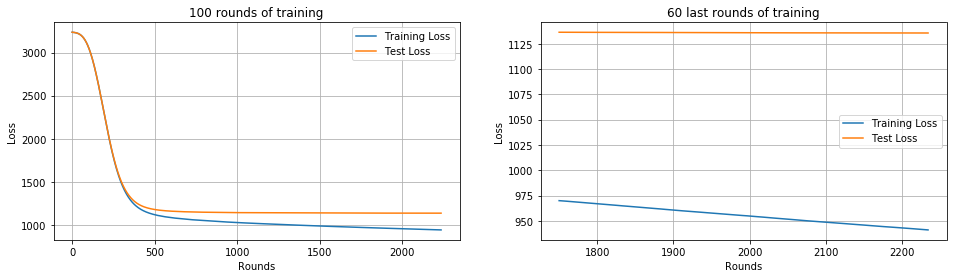

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv1[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv1.iloc[1750:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])
fig.set_size_inches(16,4)
#fig.subplots_adjust(hspace=0)
plt.show()

In [107]:
from sklearn.model_selection import StratifiedKFold
Xt = np.zeros((1000,100))
t = np.ones((1000,100))
yt=np.concatenate((np.zeros(500),np.ones(500)))
skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(Xt, yt):
    t[test_index] = 0
np.where(t)

(array([], dtype=int64), array([], dtype=int64))

In [132]:
# To follow conventional function names in sklearn, we implement fit and predict functions
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        self.num_boost_round = self.params.get('num_boost_round',120)
        self.early_stopping_rounds = self.params.get('early_stopping_rounds',10)
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, 
                             num_boost_round=self.num_boost_round,
                             feval=evalerror, maximize=False,early_stopping_rounds=None)
        return self.bst
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=evalerror, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [133]:
%%time
# The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
xgb_params = {
    'learning_rate': [0.1],
    'n_estimators':[100],
     'gamma':[0],
    'colsample_bytree': [0.5],
    'subsample': [0.5],
    'objective': ['reg:linear'],
    'max_depth': [9],
    'min_child_weight': [6],
    'nthread':[10],
    'num_boost_round':[50]
}
clf=XGBoostRegressor()
grid = GridSearchCV(clf,param_grid=xgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

-1157.47329818
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'nthread': 10, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.5, 'objective': 'reg:linear', 'num_boost_round': 50, 'max_depth': 9, 'gamma': 0}
CPU times: user 12min, sys: 6.41 s, total: 12min 7s
Wall time: 1min 15s


In [134]:
%%time
# The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
xgb_params = {
    'learning_rate': [0.1],
    'n_estimators':[100],
     'gamma':[ 0.1 * i for i in range(0,5)],
    'colsample_bytree': [0.5],
    'subsample': [0.5],
    'objective': ['reg:linear'],
    'max_depth': [9],
    'min_child_weight': [6],
    'nthread':[10],
    'num_boost_round':[150]
}
clf=XGBoostRegressor()
grid = GridSearchCV(clf,param_grid=xgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

-1156.26686109
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'nthread': 10, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.5, 'objective': 'reg:linear', 'num_boost_round': 150, 'max_depth': 9, 'gamma': 0.4}
CPU times: user 43min 4s, sys: 23.3 s, total: 43min 27s
Wall time: 4min 30s


In [135]:
%%time
# The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
xgb_params = {
    'learning_rate': [0.1],
    'n_estimators':[100],
     'gamma':[0.4],
    'subsample':[i/10.0 for i in range(1,10)],
     'colsample_bytree':[i/10.0 for i in range(1,10)],
    'objective': ['reg:linear'],
    'max_depth': [9],
    'min_child_weight': [6],
    'nthread':[10],
    'num_boost_round':[150]
}
clf=XGBoostRegressor()
grid = GridSearchCV(clf,param_grid=xgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

-1150.47117641
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'nthread': 10, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9, 'objective': 'reg:linear', 'num_boost_round': 150, 'max_depth': 9, 'gamma': 0.4}
CPU times: user 9h 6min 51s, sys: 4min 47s, total: 9h 11min 39s
Wall time: 57min 2s


In [136]:
%%time
# The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
xgb_params = {
    'learning_rate': [0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03],
    'n_estimators':[500],
     'gamma':[0.4],
    'subsample':[0.9],
     'colsample_bytree':[0.6],
    'objective': ['reg:linear'],
    'max_depth': [9],
    'min_child_weight': [6],
    'nthread':[10],
    'num_boost_round':[150]
}
clf=XGBoostRegressor()
grid = GridSearchCV(clf,param_grid=xgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

-1150.47117641
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'nthread': 10, 'min_child_weight': 6, 'n_estimators': 500, 'subsample': 0.9, 'objective': 'reg:linear', 'num_boost_round': 150, 'max_depth': 9, 'gamma': 0.4}
CPU times: user 1h 11min 42s, sys: 37 s, total: 1h 12min 19s
Wall time: 7min 28s


In [142]:
%%time
# The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
xgb_params = {
    'learning_rate': [0.1],
    'reg_alpha':[1e-5,1e-4,1e-3, 1e-2, 0.1, 1,10,100],
    'n_estimators':[100],
     'gamma':[0.4],
    'subsample':[0.9],
     'colsample_bytree':[0.6],
    'objective': ['reg:linear'],
    'max_depth': [9],
    'min_child_weight': [6],
    'nthread':[10],
    'num_boost_round':[150]
}
clf=XGBoostRegressor()
grid = GridSearchCV(clf,param_grid=xgb_params, cv=3, scoring=mae_scorer)
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

-1149.84640685
{'reg_alpha': 0.0001, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'nthread': 10, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9, 'objective': 'reg:linear', 'num_boost_round': 150, 'max_depth': 9, 'gamma': 0.4}
CPU times: user 1h 5min 45s, sys: 34.6 s, total: 1h 6min 19s
Wall time: 6min 53s


In [ ]:
if __name__ == '__main__':
    print "a+b"